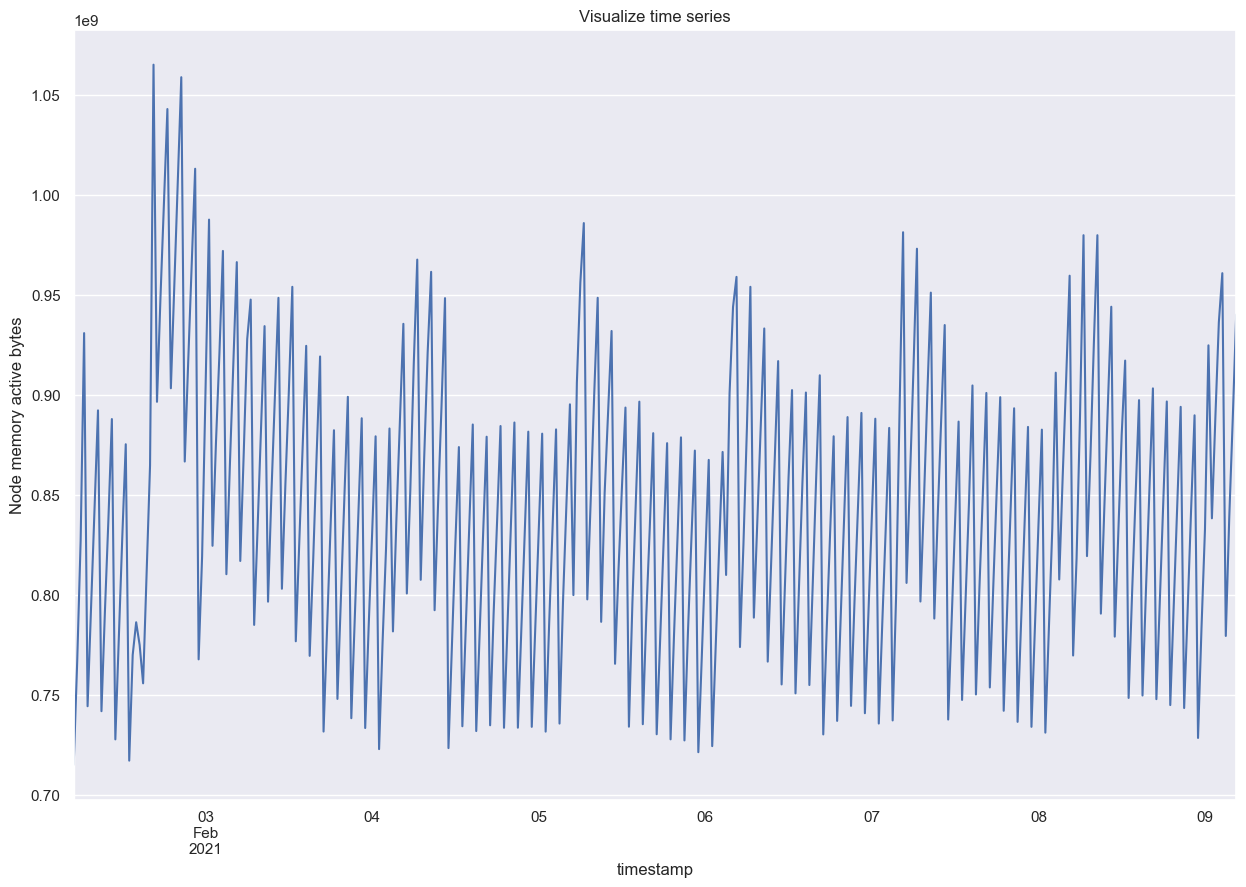

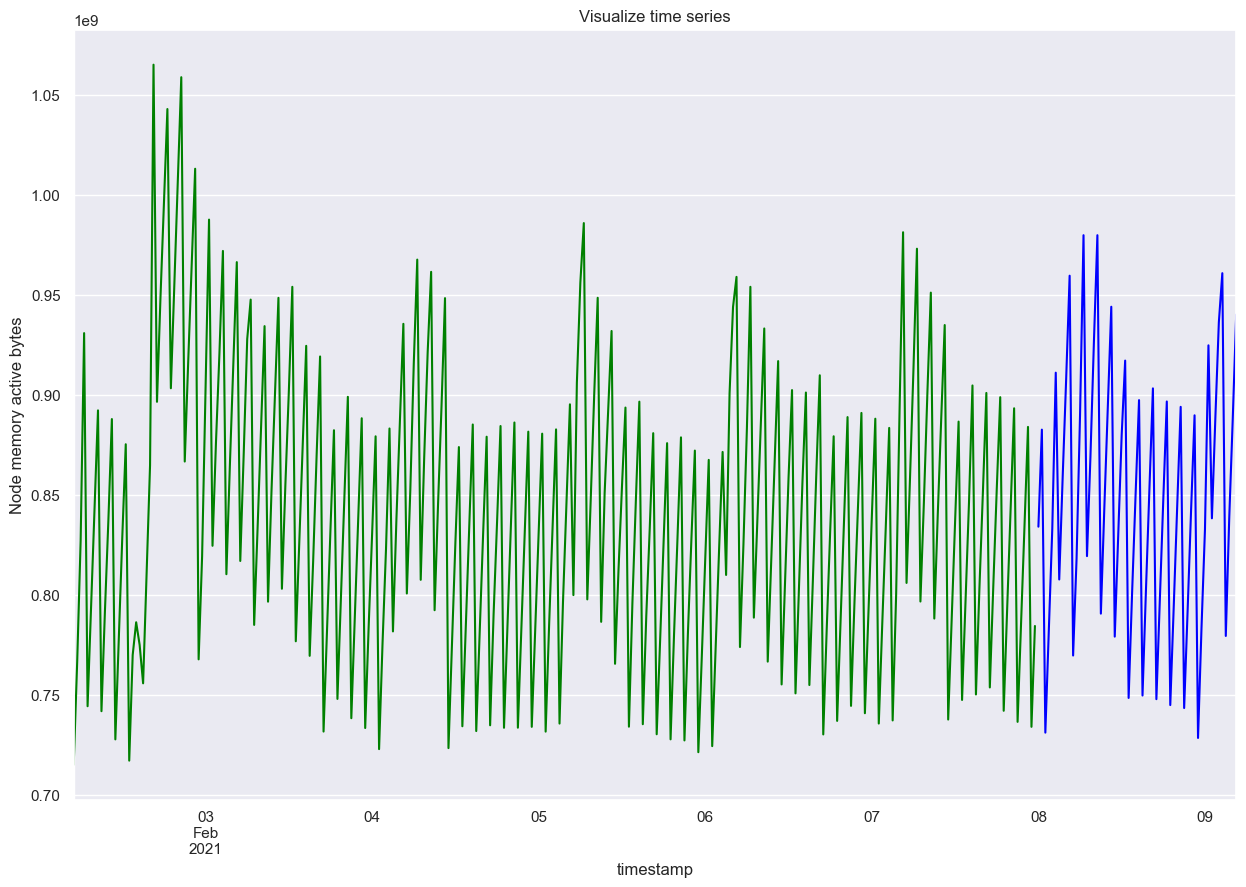

2/2 [==============================] - 0s 1ms/step
RMSE Best: 84357720.55614477
MAE Best: 35844225.499798


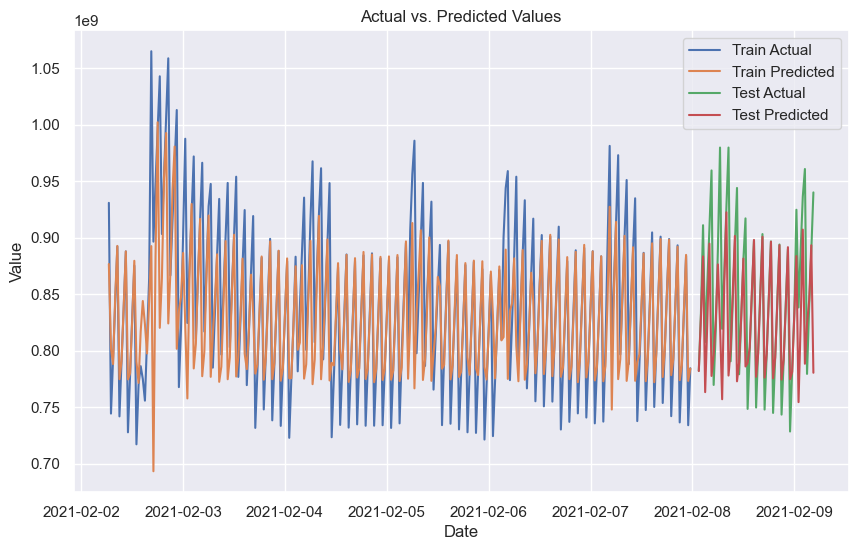

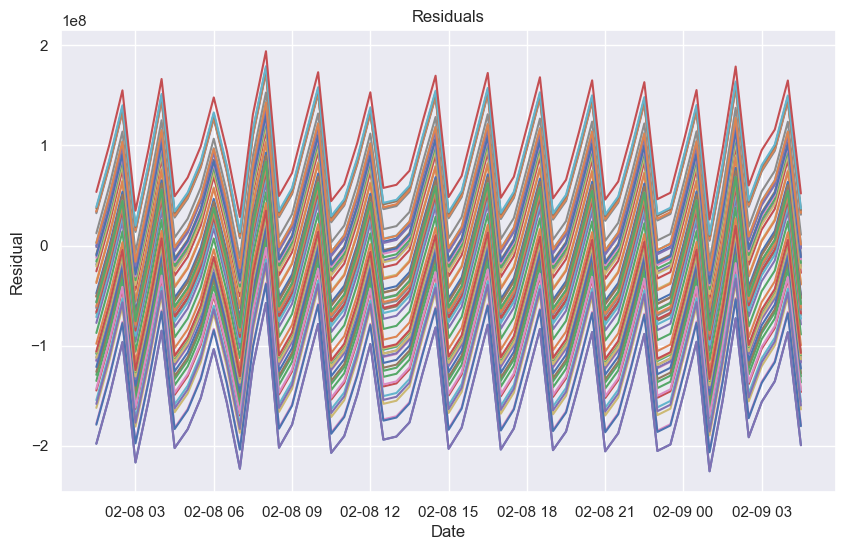

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape



# Define the objective function for MRFO
def obj_func(x, n_steps):
    n_units = int(x[0])
    n_epochs = int(x[1])
    n_features = 1

    # Define the RNN model architecture
    model = Sequential()
    model.add(Reshape((n_steps, n_features), input_shape=(n_steps,)))
    model.add(LSTM(n_units, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae')

    # Train the model
    model.fit(X_train, y_train, epochs=n_epochs, verbose=0)

    return model


# Define the MRFO algorithm
def MRFO(n, dim, n_iter, lb, ub, obj_func, n_steps):
    # Initialize the population
    X = np.random.uniform(lb, ub, (n, dim))

    # Initialize the best position and fitness
    best_position = None
    best_fitness = np.inf

    # Evaluate the fitness of the initial population
    fitness = np.zeros(n)
    for i in range(n):
        model = obj_func(X[i], n_steps)
        y_pred = model.predict(X_test)
        y_pred = scaler.inverse_transform(y_pred)
        fitness[i] = mean_absolute_error(test.values[n_steps:], y_pred)

        # Update the best position and fitness
        if fitness[i] < best_fitness:
            best_position = X[i]
            best_fitness = fitness[i]

    # Run the MRFO algorithm
    for t in range(n_iter):
        for i in range(n):
            # Generate a random vector
            r = np.random.uniform(-1, 1, dim)

            # Generate a spiral movement
            s = np.zeros(dim)
            for j in range(dim):
                s[j] = r[j] * np.sin(2 * np.pi * r[j])

            # Update the position of the current manta ray
            X[i] = X[i] + s

            # Check if the new position is within the search space
            for j in range(dim):
                if X[i][j] < lb[j]:
                    X[i][j] = lb[j]
                elif X[i][j] > ub[j]:
                    X[i][j] = ub[j]

            # Evaluate the fitness of the new position
            model = obj_func(X[i], n_steps)
            y_pred = model.predict(X_test)
            y_pred = scaler.inverse_transform(y_pred)
            new_fitness = mean_absolute_error(test.values[n_steps:], y_pred)

            # Update the best position and fitness
            if new_fitness < best_fitness:
                best_position = X[i]
                best_fitness = new_fitness

    return best_position, best_fitness


# Load the time series data
metric_df = pd.read_pickle("./data/ts.pkl")

# Resample the data to 30-minute intervals
ts = metric_df["value"].astype(float).resample("30min").mean()

# Visualize the time series
sns.set()
ts.plot(figsize=(15, 10))
plt.title("Visualize time series")
plt.ylabel("Node memory active bytes")
plt.show()


# Split the data into train and test sets
train = ts[:"2021-02-07"]
test = ts["2021-02-08":]

# Plot train and test sets
train.plot(figsize=(15, 10), color="green")
test.plot(figsize=(15, 10), color="blue")
plt.title("Visualize time series")
plt.ylabel("Node memory active bytes")
plt.show()


# Scale the data using a MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))


# Define the number of time steps
n_steps = 3

# Create sequences of input data and target values for train set
X_train, y_train = [], []
for i in range(n_steps, len(train_scaled)):
    X_train.append(train_scaled[i-n_steps:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the input data to be 3D
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))

# Create sequences of input data and target values for test set
X_test, y_test = [], []
for i in range(n_steps, len(test_scaled)):
    X_test.append(test_scaled[i-n_steps:i, 0])
    y_test.append(test_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Define the search space for MRFO
n = 20
dim = 2
n_iter = 2
lb = [10, 1]
ub = [100, 100]

# Run MRFO
best_position, best_fitness = MRFO(n, dim, n_iter, lb, ub, obj_func, n_steps)

# Extract the best hyperparameters
n_units, n_epochs = map(int, best_position)

# Train the final model with the best hyperparameters
final_model = obj_func(best_position, n_steps)
final_model.fit(X_train, y_train, epochs=n_epochs, verbose=0)

# Make predictions on the train and test sets
train_pred = final_model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred)
test_pred = final_model.predict(X_test)
test_pred = scaler.inverse_transform(test_pred)

# Evaluate the model on the test set
rmse = np.sqrt(np.mean((test_pred - test.values)**2))
print("RMSE Best:", rmse)

# Evaluate the model on the test set
mae = mean_absolute_error(test.values[n_steps:], test_pred)
print("MAE Best:", mae)

# Plot the actual and predicted values for train and test sets
plt.figure(figsize=(10, 6))
plt.plot(train.index[n_steps:], train.values[n_steps:], label="Train Actual")
plt.plot(train.index[n_steps:], train_pred, label="Train Predicted")
plt.plot(test.index[n_steps:], test.values[n_steps:], label="Test Actual")
plt.plot(test.index[n_steps:], test_pred, label="Test Predicted")
plt.legend()
plt.title("Actual vs. Predicted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

# Plot the residuals
residuals = test_pred - test.values[n_steps:]
plt.figure(figsize=(10, 6))
plt.plot(test.index[n_steps:], residuals)
plt.title("Residuals")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.show()